# Ex8.8 Trajectory Sampling Exercise

## 0. Problem Definitions

* undiscounted episodic tasks
* 2 actions from each state, each resulting in one of $b$ states, all equally likely
* different random selection of $b$ states for each state-action pair
* for each transition theres a $0.1$ chance of entering a terminal state
* expected reward for each transition sampled from $\mathcal{N}(0,1)$

## 1. Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Environment:
    def __init__(self, state_amount, actions, branching_factor):
        self.states   = state_amount
        self.actions  = actions
        self.branches = branching_factor
        self.t_chance = 0.1
                
    def reset(self):
        np.random.seed(0)
        self.build_transition_graph()
        
    def build_transition_graph(self):
        '''Transition graph includes next state and reward for getting there'''
        self.trans = np.random.randint(self.states, size=(self.states, self.actions, self.branches, 2))
        
        for state in range(self.states):
            for action in range(self.actions):
                for branch in range(self.branches):
                    self.trans[state, action, branch, 1] = np.random.normal()
    
    def get_start(self):
        '''Return the starting position (arbitrary but constant)'''
        return 0
    
    def get_random_branch(self):
        '''Choose a random branch'''
        return np.random.randint(self.branches)

    def is_terminal(self):
        '''Call to determine if move is terminal'''
        return np.random.rand() < self.t_chance

## 2. One Step Tabular Planning

In [3]:
class TabularPlanning:
    
    def __init__(self, environment, mod, exp_updates):
        self.env         = environment
        self.alpha       = 0.9
        self.gamma       = 1
        self.epsilon     = 0.1
        self.mod         = mod
        self.exp_updates = exp_updates
        
    def reset(self):
        '''Reset Seed, State-Action Value Function and History of Start-State Values'''
        self.Q    = np.zeros((self.env.states, self.env.actions))
        self.hist = np.zeros(self.exp_updates // self.mod)
        
    def step(self, S, A):
        '''Move according to Environment - get new State and Reward'''
        B     = self.env.get_random_branch()
        Sn, R = self.env.trans[S, A, B]
        return Sn, R
    
    def update_q(self, S, A, R, Sn):
        '''Update State-Action Value Function with given transition'''
        Am   = np.argmax(self.Q[Sn])
        idx  = (S,  A)
        idxn = (Sn, Am)
        self.Q[idx] += (1 - self.env.t_chance) * \
                       (1 / self.env.branches) * \
                       self.alpha * (R + self.gamma * self.Q[idxn] - self.Q[idx])
        
    def epsilon_greedy(self, S, epsilon=None):
        '''Epsilon-Greedy Policy for selecting an Action'''
        if epsilon is None:
            epsilon = self.epsilon
            
        if np.random.rand() > epsilon:
            return np.argmax(self.Q[S])
        else:
            return np.random.randint(self.env.actions)
        
    def train_uniform(self):
        '''Train uniformly by iterating over all states and their actions
        and then updating them inplace'''
        updates = 0
        
        while True:
            for S in range(self.env.states):
                for A in range(self.env.actions):
                    if updates < self.exp_updates:
                        Sn, R = self.step(S, A)

                        self.update_q(S, A, R, Sn)
                        if updates % self.mod == 0:
                            self.hist[updates // self.mod] = self.get_start_state_value()
                    else:
                        return self.hist
                    
                    updates += 1
        
    def train_trajectory_sample(self):
        '''Train according to a Epsilon-Greedy Policy'''
        updates = 0
        
        while True:
            S = self.env.get_start()

            while not self.is_done():
                if updates < self.exp_updates:
                    A     = self.epsilon_greedy(S)
                    Sn, R = self.step(S, A)
                    
                    self.update_q(S, A, R, Sn)
                    S = Sn
                    
                    if updates % self.mod == 0:
                        self.hist[updates // self.mod] = self.get_start_state_value()
                else:
                    return self.hist
                
                updates += 1
                
    def get_start_state_value(self):
        '''Follow Greedy Policy on Q and sum up rewards'''
        start   = self.env.get_start()
        values  = []
        updates = 0
        run_lim = 200
        
        while True:
            S = start
            
            while not self.is_done():
                if updates < run_lim:
                    A     = self.epsilon_greedy(S, epsilon=0)
                    S, R  = self.step(S, A)
                    values.append(R)
                else:
                    return np.mean(values)
                
                updates += 1
    
    def is_done(self):
        '''True if the environment decides it's over'''
        return self.env.is_terminal()

## 3. Training

In [4]:
# World Parameters
state_amount1     = 1000
state_amount2     = 10000
actions           = 2
branching_factor1 = 1
branching_factor2 = 3
branching_factor3 = 10
mod1              = 200
mod2              = 2000

# Agent Parameters
alpha             = 0.9
gamma             = 1
epsilon           = 0.1
exp_updates1      = 20000
exp_updates2      = 200000
world1            = Environment(state_amount1, actions, branching_factor1)
world2            = Environment(state_amount1, actions, branching_factor2)
world3            = Environment(state_amount1, actions, branching_factor3)
world4            = Environment(state_amount2, actions, branching_factor1)
world5            = Environment(state_amount2, actions, branching_factor2)

# Agent Definitions
agent_uniform1    = TabularPlanning(world1, mod1, exp_updates1)
agent_traject1    = TabularPlanning(world1, mod1, exp_updates1)
agent_uniform2    = TabularPlanning(world2, mod1, exp_updates1)
agent_traject2    = TabularPlanning(world2, mod1, exp_updates1)
agent_uniform3    = TabularPlanning(world3, mod1, exp_updates1)
agent_traject3    = TabularPlanning(world3, mod1, exp_updates1)
agent_uniform4    = TabularPlanning(world4, mod2, exp_updates2)
agent_traject4    = TabularPlanning(world4, mod2, exp_updates2)
agent_uniform5    = TabularPlanning(world5, mod2, exp_updates2)
agent_traject5    = TabularPlanning(world5, mod2, exp_updates2)

worlds = [world1, world2, world3, world4, world5]
agents = [agent_uniform1, agent_uniform2, agent_uniform3, agent_uniform4, agent_uniform5,
          agent_traject1, agent_traject2, agent_traject3, agent_traject4, agent_traject5]

for world in worlds:
    world.reset()
    
for agent in agents:
    agent.reset()

### 3.1 1,000 States, Branching Factor 1

In [5]:
uniform_reward1 = agent_uniform1.train_uniform()
traject_reward1 = agent_traject1.train_trajectory_sample()

### 3.2 1,000 States, Branching Factor 3

In [6]:
uniform_reward2 = agent_uniform2.train_uniform()
traject_reward2 = agent_traject2.train_trajectory_sample()

### 3.2 1,000 States, Branching Factor 10

In [7]:
uniform_reward3 = agent_uniform3.train_uniform()
traject_reward3 = agent_traject3.train_trajectory_sample()

### 3.3 10,000 States,  Branching Factor 1

In [8]:
uniform_reward4 = agent_uniform4.train_uniform()
traject_reward4 = agent_traject4.train_trajectory_sample()

### 3.4 10,000 States, Branching Factor 3

In [9]:
uniform_reward5 = agent_uniform5.train_uniform()
traject_reward5 = agent_traject5.train_trajectory_sample()

## 4. Plot

In [10]:
def plot(reward_uniform, reward_on_policy, exp_updates, mod):
    x = np.arange(exp_updates // mod) * mod
    plt.plot(x, reward_uniform,   label='uniform')
    plt.plot(x, reward_on_policy, label='on-policy')
    plt.xlabel('Expected Updates')
    plt.ylabel('Value of Start State')
    plt.legend()
    plt.show()

### 4.1 1,000 States, Branching Factor 1
Looking really good, plot looks as expected

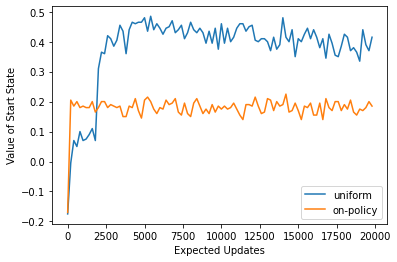

In [11]:
plot(uniform_reward1, traject_reward1, exp_updates1, mod1)

### 4.2 1,000 States, Branching Factor 3
Looking messier, but still decent

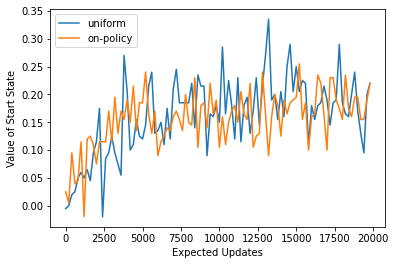

In [12]:
plot(uniform_reward2, traject_reward2, exp_updates1, mod1)

### 4.3 1,000 States, Branching Factor 10
Fairly chaotic, but effect still recognizable in the beginning

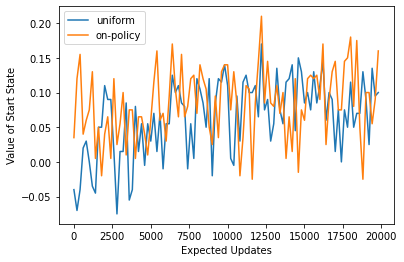

In [13]:
plot(uniform_reward3, traject_reward3, exp_updates1, mod1)

### 4.4 10,000 States, Branching Factor 1

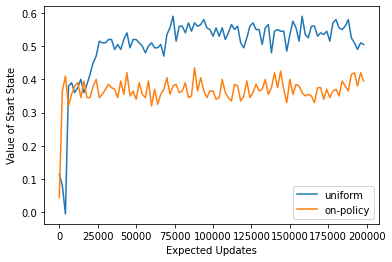

In [14]:
plot(uniform_reward4, traject_reward4, exp_updates2, mod2)

### 4.5 10,000 States, Branching Factor 3

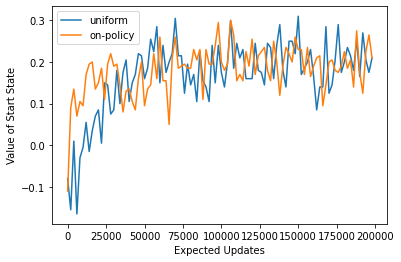

In [15]:
plot(uniform_reward5, traject_reward5, exp_updates2, mod2)